# Прогнозирование временных рядов с использованием XGBoost


В этом блокноте мы рассмотрим прогнозирование временных рядов с помощью XGBoost. Мы будем использовать данные о почасовом потреблении энергии.

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor

# Данные
Мы будем использовать данные о почасовом потреблении энергии от компании PJM. 

In [4]:
pjme = pd.read_csv('data/PJME_hourly.zip', index_col=[0], parse_dates=[0])

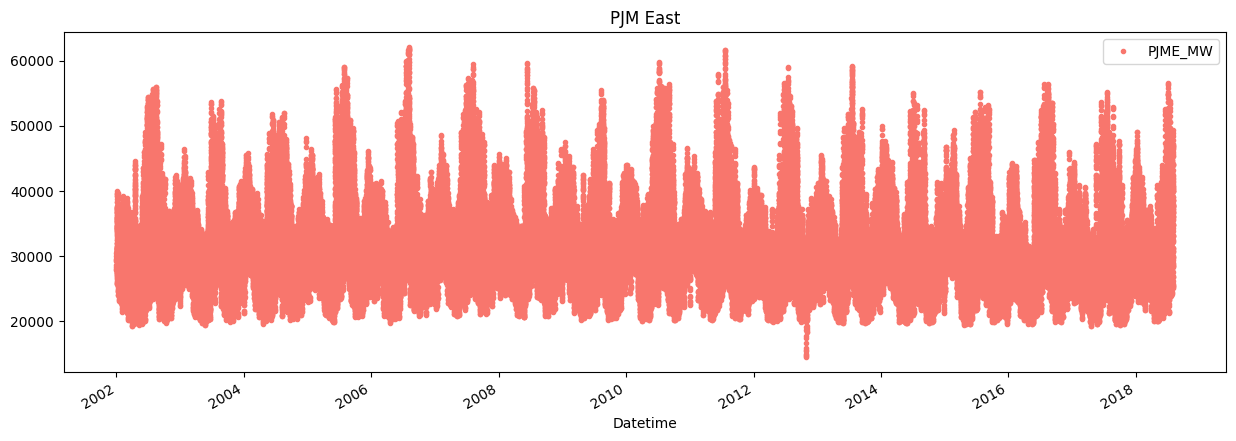

In [5]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

# Train / Test Split
Отрежем данные после 2015 года, чтобы использовать их в качестве набора для проверки.

In [6]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

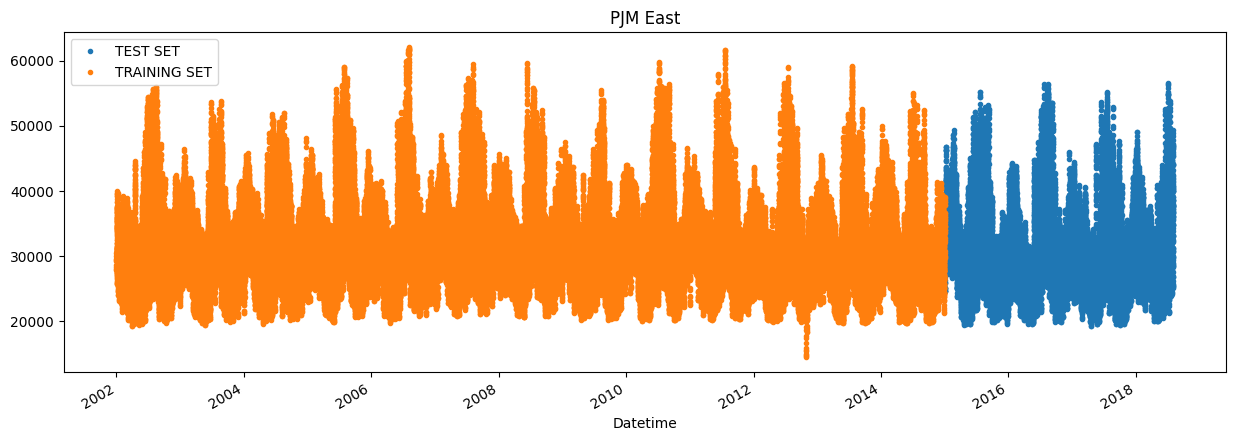

In [7]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

# Создадим признаки

In [8]:
def create_features(df, label=None):
    """
    создаем признаки из datetime индекса
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [9]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

# Создадим XGBoost Model

In [10]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False) # Измените verbose на True, если хотите увидеть процесс обучения

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Важность признаков
Важность признаков - отличный способ получить общее представление о том, на какие признаки модель больше всего полагается при прогнозировании. Это показатель, который просто суммирует, сколько раз каждая функция была разделена. Можно посмотреть с помощью plot_importance


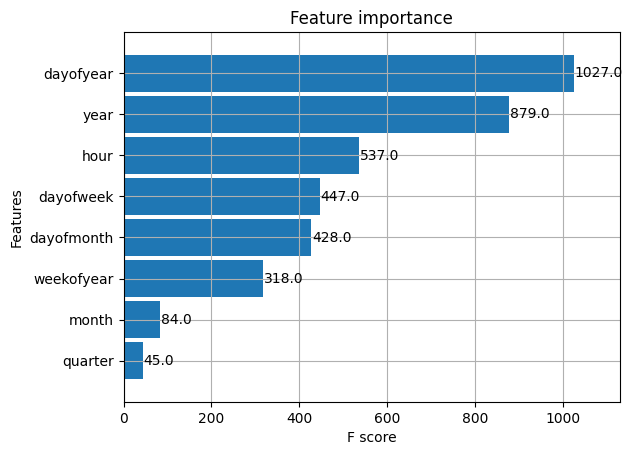

In [11]:
_ = plot_importance(reg, height=0.9)


Мы видим, что день года чаще всего использовался для разделения деревьев, а затем следуют час и год. Квартал имеет невысокую важность в связи с тем, что он мог быть создан разным разбиением по дням и годам.

# Предсказание на Test Set

In [12]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

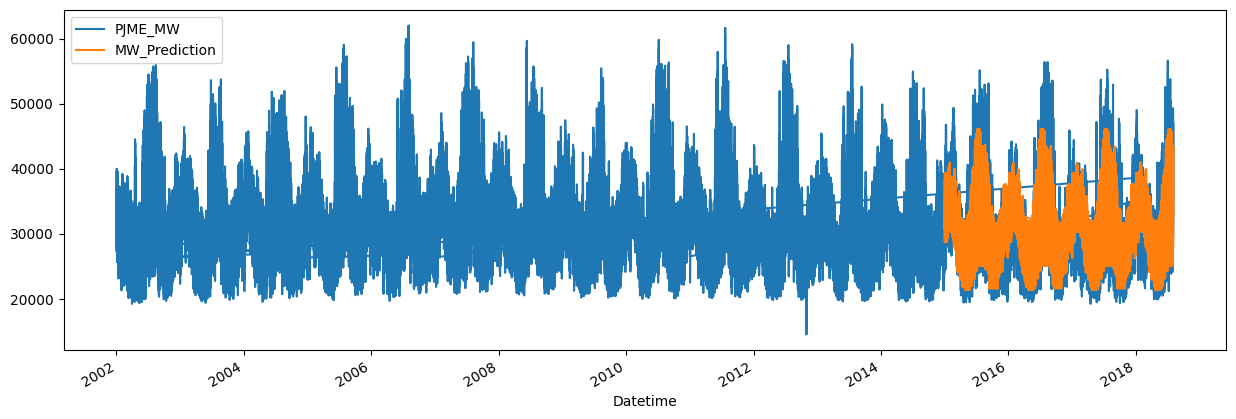

In [13]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

# Посмотрим на первый месяц прогнозов

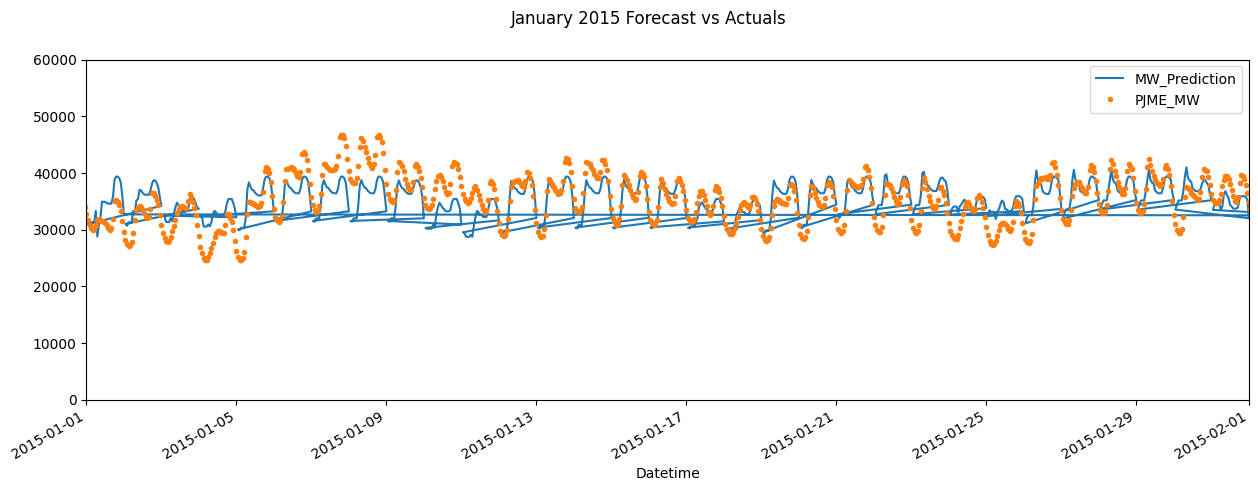

In [14]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

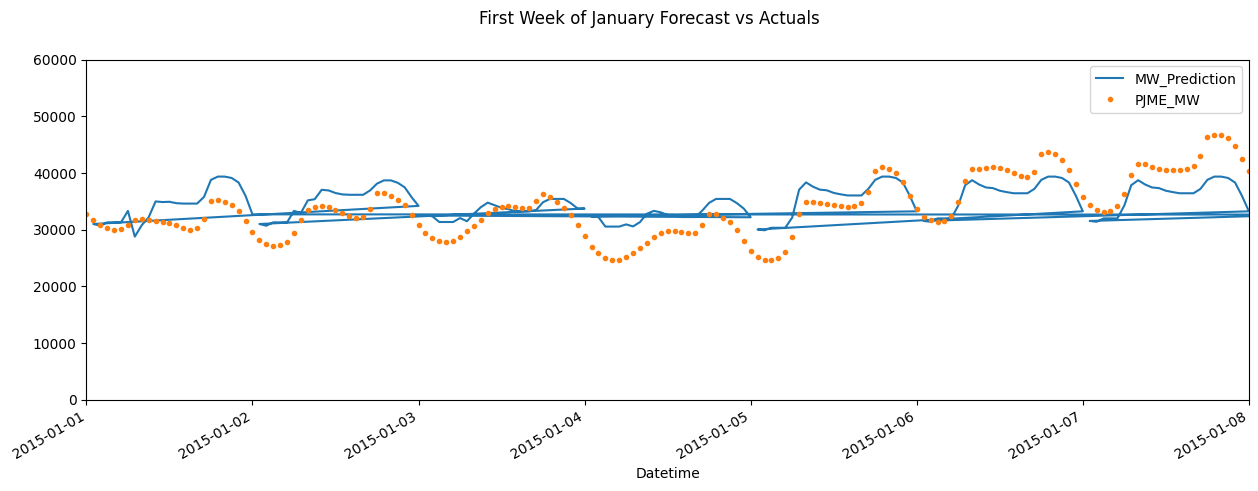

In [15]:
# Построим прогноз с фактическими данными
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

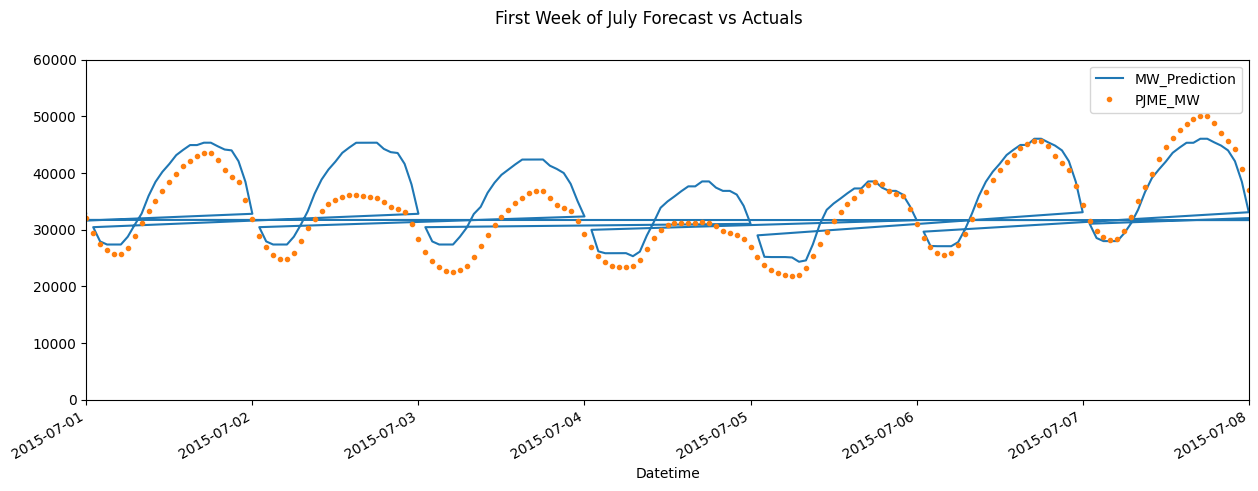

In [16]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Ошибки на Test Set
 RMSE  is 13780445  
 MAE  is 2848.89  
 MAPE  is 8.9%

In [17]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

14055329.714256588

In [18]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2905.541158635075

Неплохо использовать средний абсолютный процент ошибки, потому что он дает легко интерпретируемый процент, показывающий, насколько ошибочны прогнозы.
MAPE не включен в sklearn, поэтому нам нужно использовать настраиваемую функцию.

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """считаем MAPE по y_true и y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

9.239324261253785

# Посмотрим на худшие и лучшие прогнозируемые дни

In [21]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [22]:
# За прогнозные дни
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   37517.796875 -9117.839681  9117.839681
2017 2     24          26445.083333   34674.246094 -8229.161458  8229.161458
           25          24344.458333   32168.185547 -7823.726562  7823.726562
           20          27070.583333   34739.832031 -7669.247314  7669.247314
           23          27663.416667   35189.988281 -7526.572591  7526.572591
           19          24555.500000   32075.916016 -7520.415690  7520.415690
2018 2     21          27572.500000   35071.636719 -7499.138509  7499.138509
2017 2     28          28297.875000   35777.996094 -7480.123128  7480.123128
2015 12    25          24466.083333   31934.242188 -7468.158447  7468.158447
2017 5     29          24528.416667   31898.537109 -7370.119873  7370.119873


- Худший день №1 - 4 июля 2016 года - выходной.
- Худший день # 3 - 25 декабря 2015 - Рождество
- Худший день №5 - 4 июля 2016 года - выходной.

Похоже, наша модель может улучшиться после добавления индикатора праздника.

In [23]:
# Худшие абсолютные прогнозируемые дни
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31933.914062  13251.918294  13251.918294
           14          44427.333333   31571.750000  12855.583659  12855.583659
     9     10          40996.166667   29232.009766  11764.157145  11764.157145
           9           43836.958333   32909.222656  10927.734863  10927.734863
2018 1     6           43565.750000   33295.785156  10269.967285  10269.967285
2016 8     12          45724.708333   35532.207031  10192.502441  10192.502441
2015 2     20          44694.041667   34555.894531  10138.147624  10138.147624
2018 1     7           42159.708333   32626.416016   9533.292318   9533.292318
2017 5     19          38032.583333   28695.617188   9336.965169   9336.965169
2015 2     16          43949.500000   34774.941406   9174.557210   9174.557210

Больше хорошо спрогнозируемых дней в октябре (не много праздников). Также ранний май.

In [24]:
# Лучшие прогнозируемые дни
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 12    30          32213.458333   32181.333984   32.125244  293.829183
     10    27          28611.166667   28468.591797  142.576579  395.899007
2017 10    24          28657.416667   28500.578125  156.839274  418.409749
2015 10    28          28500.958333   28500.578125    0.380941  437.252360
     5     6           28948.666667   28924.179688   24.486898  467.199788
2016 8     8           36256.041667   36075.062500  180.978190  565.314616
2017 9     14          32033.875000   31962.031250   71.842448  596.341634
     5     2           28546.916667   28924.179688 -377.263102  596.743408
     8     12          31822.666667   32056.876953 -234.211263  597.051595
2016 12    12          32757.208333   33159.648438 -402.439290  597.560872

# Построение лучших / худших прогнозируемых дней

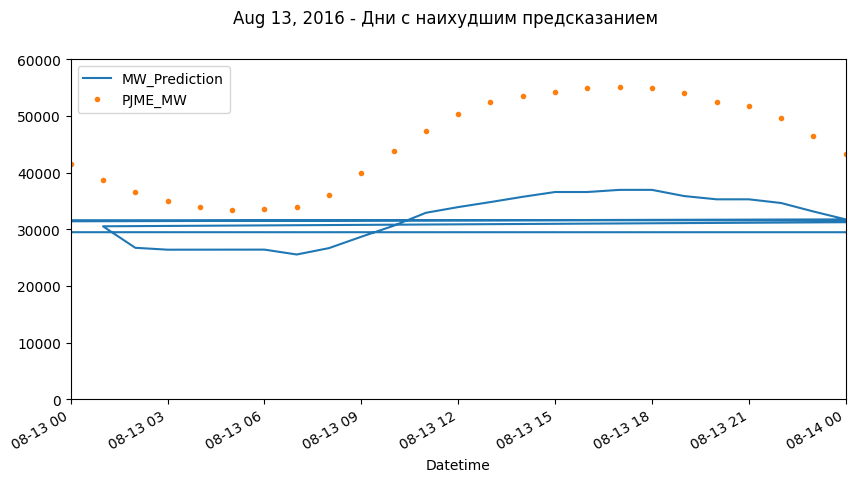

In [25]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Дни с наихудшим предсказанием')

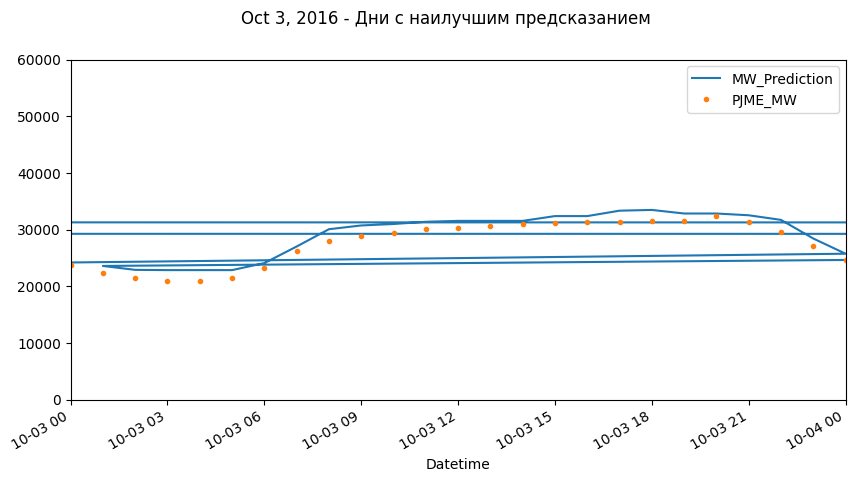

In [26]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Дни с наилучшим предсказанием')

# Сравним с CatBoost

In [27]:
cbr = CatBoostRegressor(n_estimators=1000)
cbr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

In [28]:
pjme_test['MW_Prediction_catboost'] = cbr.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

In [29]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_catboost']), mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_catboost'])

(13809143.554783195, 2865.921219373833)

In [30]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_catboost'])

9.038216251598783

Ошибка не сильно отличается от результатов XGBoost, но как правило, требуется дополнительная настройка модели и добавление признаков.

# Что дальше?
- Можно добавить лаги
- Добавить праздники
- Добавить погодные условия